## Introduction

# King’s Super Math Saga experiment

The assignment table contains players assigned to the A/B test and attributes related to each player.
1. playerid: Unique numeric identifier for each player
2. abtest_group: The group the player was assigned to (A or B)
3. assignment_date: The date when the player was assigned to the test
4. install_date: The date when the player installed the game
5. conversion_date: The date when the player made their first purchase

The activity table contains player activity for each day a player was active.
1. playerid: Unique numeric identifier for each player
2. activity_date: The date of activity
3. purchases: Number of purchases made this day
4. gameends: Number of gamerounds played this day

### Packages

In [2]:
# import packages

# Basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# GCP
import pandas_gbq
import db_dtypes

# Hypothesis Testing
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import ttest_ind

# Clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pickle

# Configuration
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

### Hypothesis Test

Assumptions:

    - Check for normality
    - If normal distribution, check for homogeneity

Steps:

    - Apply Shapiro Test for normality
    - If parametric, apply Levene Test for homogeneity of variances
    - If parametric + homogeneity of variances apply T-Test
    - If parametric - homogeneity of variances apply Welch Test
    - If non-parametric apply Mann Whitney U Test

In [3]:
# define function that checks assumptions and applies appropriate hypothesis test
def hypothesis_test(test, control, alternative="two-sided"):

    # import packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # check for normality:
    ntA = shapiro(test)[1] < 0.05
    ntB = shapiro(control)[1] < 0.05

    if (ntA == False) & (ntB == False): 
        # parametric test
        # check for homogeneity
        leveneTest = stats.levene(test, control)[1] < 0.05

        if leveneTest == False: # homogeneus
            ttest = stats.ttest_ind(test, control, equal_var=True, alternative=alternative)
        else: # heterogeneous
            ttest = stats.ttest_ind(test, control, equal_var=False, alternative=alternative)
    else:
        # non-parametric test
        ttest = stats.mannwhitneyu(test, control, alternative=alternative)

    return ttest

## 1. Data Extraction & Prep

In [13]:
# define function to query data from gcp and transform it into df
def gcp2df(query):
    project_id = 'king-ds-recruit-candidate-635'
    return pd.read_gbq(query, project_id=project_id, dialect='standard')

In [27]:
query = ('''
WITH

activity AS (
SELECT playerid, SUM(purchases) AS total_purchases, SUM(gameends) as total_gameends, COUNT(activity_date) AS days_played
    FROM `king-ds-recruit-candidate-635.abtest.activity` 
    WHERE activity_date BETWEEN "2017-05-04" AND "2017-05-22"
    GROUP BY playerid
),

joinTables AS (
SELECT ass.*, ac.total_gameends, ac.total_purchases, ac.days_played
FROM `king-ds-recruit-candidate-635.abtest.assignment` AS ass
LEFT JOIN  activity AS ac
ON ass.playerid=ac.playerid
)

SELECT *
FROM joinTables
    ''')

df = gcp2df(query)

In [28]:
#df.to_csv("../../../king.csv")

In [35]:
df = pd.read_csv("../../../king.csv", index_col=0)

In [4]:
df.head()

,playerid,abtest_group,assignment_date,install_date,conversion_date,total_gameends,total_purchases,days_played
0,12375489,A,2017-05-04,2016-05-02,NaN,204,0,16
1,30548310,A,2017-05-04,2016-11-01,NaN,247,0,13
2,41099711,A,2017-05-04,2017-02-13,NaN,159,0,13
3,26239061,A,2017-05-04,2016-09-19,NaN,56,0,6
4,6191990,A,2017-05-04,2016-03-02,NaN,98,0,14


In [36]:
 # format date variables into datetime
df[["assignment_date", "install_date", "conversion_date"]] = df[["assignment_date", "install_date", 
                                                                "conversion_date"]].apply(pd.to_datetime)

In [37]:
# create more meaningful and actionable variables form datetime variables
df["days_since_installed"] = (df.assignment_date.max() - df.install_date).dt.days # time since a player installed the game in days
df["days_to_convert"] = (df.conversion_date - df.install_date).dt.days # time it takes players to convert after installing the game in days

In [38]:
# create paying users based on whether a player is 
df["paying_user"] = df.conversion_date.notnull()

In [39]:
# create a player_type variable that segments players by days_since_installed
# The split is determined by business sense
conditions = [
    (df.days_since_installed <= 19), # new players that haven't seen the control version
    (df.days_since_installed > 19) & (df.days_since_installed <= 90),
    (df.days_since_installed > 90)]
values = ["newbie", "experienced", "OG"]
df["player_type"] = np.select(conditions, values)

In [40]:
# create a retention metric based on number of days played
df["day_2_retention"] = df.days_played > 1
df["day_7_retention"] = df.days_played > 6

In [10]:
df.head() # contains aggregated gameround and purchase data for the whole experiment

,playerid,abtest_group,assignment_date,install_date,conversion_date,total_gameends,total_purchases,days_played,days_since_installed,days_to_convert,paying_user,player_type,day_2_retention,day_7_retention
0,12375489,A,2017-05-04,2016-05-02,NaT,204,0,16,385,NaN,False,OG,True,True
1,30548310,A,2017-05-04,2016-11-01,NaT,247,0,13,202,NaN,False,OG,True,True
2,41099711,A,2017-05-04,2017-02-13,NaT,159,0,13,98,NaN,False,OG,True,True
3,26239061,A,2017-05-04,2016-09-19,NaT,56,0,6,245,NaN,False,OG,True,False
4,6191990,A,2017-05-04,2016-03-02,NaT,98,0,14,446,NaN,False,OG,True,True


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10331056 entries, 0 to 10331055
Data columns (total 14 columns):
 #   Column                Dtype         
---  ------                -----         
 0   playerid              int64         
 1   abtest_group          object        
 2   assignment_date       datetime64[ns]
 3   install_date          datetime64[ns]
 4   conversion_date       datetime64[ns]
 5   total_gameends        int64         
 6   total_purchases       int64         
 7   days_played           int64         
 8   days_since_installed  int64         
 9   days_to_convert       float64       
 10  paying_user           bool          
 11  player_type           object        
 12  day_2_retention       bool          
 13  day_7_retention       bool          
dtypes: bool(3), datetime64[ns](3), float64(1), int64(5), object(2)
memory usage: 975.4+ MB


In [41]:
# split control and test results
control_results = df[df["abtest_group"]=="A"]
test_results = df[df["abtest_group"]=="B"]

## 2. Metric Analysis

### Invariant metrics: *

    - playerid
    - days_since_installed

*Invariant metrics are those which should not change across control and experiment groups. If players were randomly assigned, we would expect the distributions of these metrics to stay consistent between the test and control sets, or else there is something fundamentally wrong with the experiment setup.

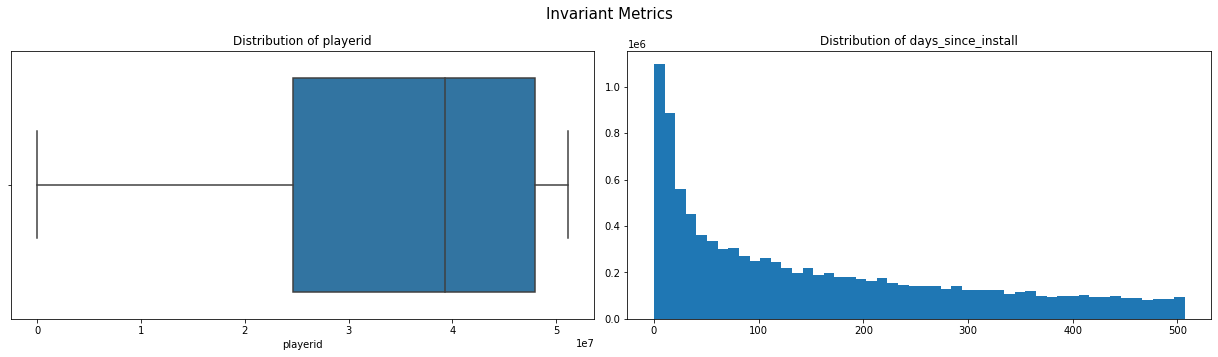

In [307]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
sns.boxplot(df.playerid, ax=ax[0])
ax[1].hist(df.days_since_installed, bins=50)

fig.suptitle("Invariant Metrics", fontsize=15)
ax[0].set_title("Distribution of playerid", fontsize = 12)
ax[1].set_title("Distribution of days_since_install", fontsize = 12)
plt.tight_layout(pad = 1)
plt.show()

#### Observations:

Most active players installed the game during the last few months.

### Evaluation metrics:

    - total_gameends
    - total_purchases
    - day 2 and day 7 retention
    - share of paying users
    - days_to_convert

In [60]:
df[["total_gameends", "total_purchases", "days_to_convert"]].describe()

,total_gameends,total_purchases,days_to_convert
count,1.033106e+07,1.033106e+07,285923.000000
mean,1.579491e+02,3.714809e-01,2.720886
std,1.391929e+02,9.515109e+00,4.501814
min,0.000000e+00,0.000000e+00,0.000000
25%,9.500000e+01,0.000000e+00,0.000000
50%,1.290000e+02,0.000000e+00,1.000000
75%,1.820000e+02,0.000000e+00,4.000000
max,1.932000e+03,5.690000e+03,84.000000


In [61]:
df[["day_2_retention", "day_7_retention"]].mean()

day_2_retention    0.921677
day_7_retention    0.834508
dtype: float64

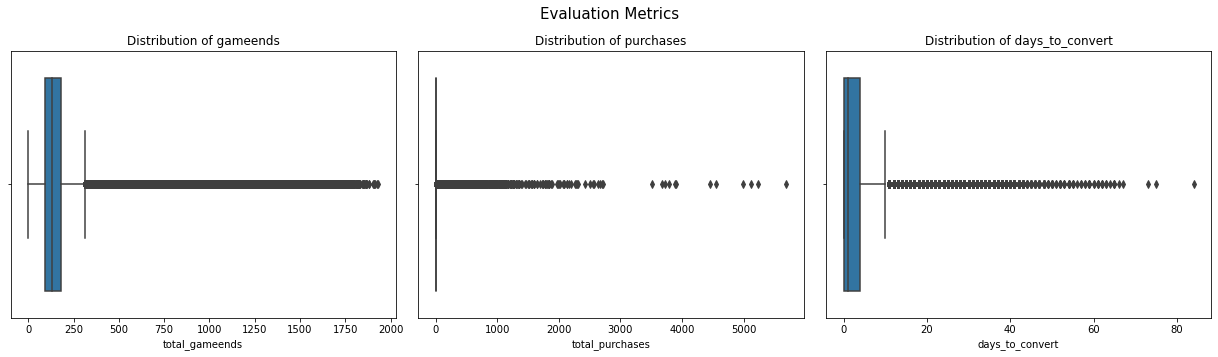

In [309]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5))
sns.boxplot(df.total_gameends, ax=ax[0])
sns.boxplot(df.total_purchases, ax=ax[1])
sns.boxplot(df.days_to_convert, ax=ax[2])

fig.suptitle("Evaluation Metrics", fontsize=15)
ax[0].set_title("Distribution of gameends", fontsize = 12)
ax[1].set_title("Distribution of purchases", fontsize = 12)
ax[2].set_title("Distribution of days_to_convert", fontsize = 12)
plt.tight_layout(pad = 1)
plt.show()

### Data Description

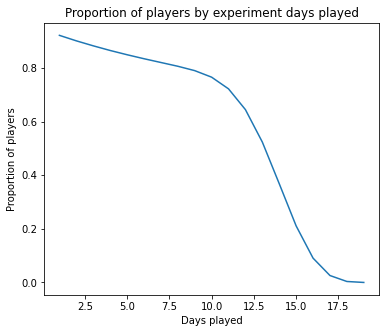

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
(1-(df.days_played.value_counts(normalize=True, sort=False).cumsum())).plot()

plt.title("Proportion of players by experiment days played", fontsize = 12)
plt.ylabel("Proportion of players")
plt.xlabel("Days played")
plt.show()

In [121]:
# share of paying users
df.paying_user.value_counts(normalize=True)

False    0.972324
True     0.027676
Name: paying_user, dtype: float64

#### Observations:

Most players are Free-to-play. The share of paying users is around 2.8%.

Most paying users convert during the first few days of playing the game. If a player doesn't pay early on, is highly unlikely that they will end up paying. 

There is a high variance between the gamerounds and purchases made by different players. All paying users are considered outliers.

Some players have made more purchases than rounds played. This suggests that there are multiple hints in a level.

## 3. Sanity Checks

#### What checks can we do to be confident in the validity of the test?

In [311]:
# Are there duplicated playerids?
df.playerid.duplicated().any()

False

In [312]:
# Do the control and test groups contain 80 and 20 percent of the players respectively?
df.abtest_group.value_counts(normalize=True)

A    0.800074
B    0.199926
Name: abtest_group, dtype: float64

#### Checking invariants: are the distributions of invariant metrics for control and test groups the same?

In [317]:
# playerid
print(df.groupby("abtest_group").playerid.mean())
print(hypothesis_test(control_results.days_since_installed, test_results.days_since_installed))

abtest_group
A    34979639.729978
B    34983333.536522
Name: playerid, dtype: Float64
MannwhitneyuResult(statistic=8538072968530.0, pvalue=0.6041776844973805)


In [315]:
# days_since_installed
print(df.groupby("abtest_group").days_since_installed.mean())
print(hypothesis_test(control_results.days_since_installed, test_results.days_since_installed))

abtest_group
A    159.306688
B    159.269564
Name: days_since_installed, dtype: float64
MannwhitneyuResult(statistic=8538072968530.0, pvalue=0.6041776844973805)


All the invariant metrics pass the test. The means of the distributions are very similar and we cannot reject that the underlying distribution is the same for the control and test groups. 

Since everything looks alright, we will go on and analyze the results of our evaluation metrics.

## 4. Results Analysis

### Aggregated Data

To consider the results as positive, we would like to see that the change made to the game, aka treatment, will result in a greater engagement and/or number of purchases. 

Thus, our null hypothesis (H0) and alternative hypothesis (Ha) are as follows:  

    - H0: There is no difference in the average number of gamerounds and/or purchases in the test and control groups.
    - Ha: The average number of gamerounds and/or purchases of the test group is greater than the control group.

Since the alternative hypothesis states that the true value of the parameter specified in the null hypothesis is greater than the null hypothesis claims, we will use a right-tailed test.

We choose our significance level to be 0.05. Thus, if p<=0.05, we reject the H0.

Let's first look into the gameround and purchases summary statistics for the different abtest_groups. 

In [122]:
df[["abtest_group", "total_gameends", "total_purchases", "day_2_retention", "day_7_retention", "days_to_convert", "paying_user"]].groupby(by="abtest_group").agg(["count", 
                                                                "median", "mean", "std", "max"]).style.format('{:.3f}')

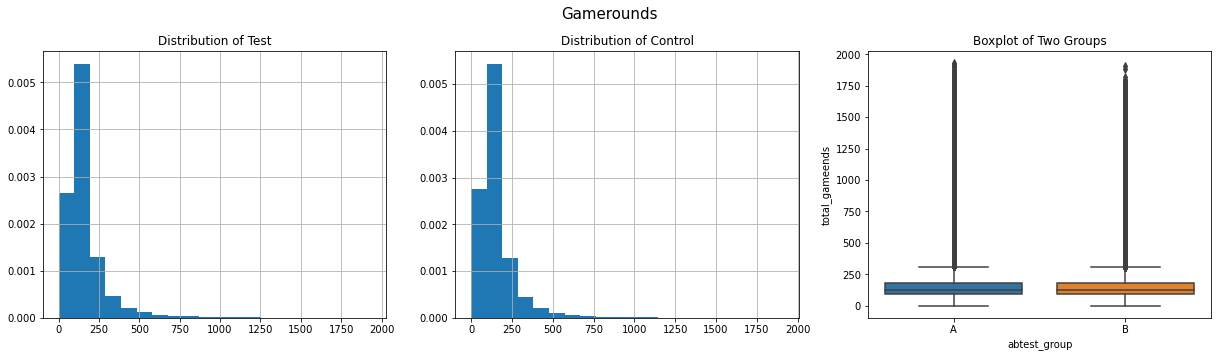

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5))
control_results.hist("total_gameends", density=True, bins= 20, ax=ax[0])
test_results.hist("total_gameends", density=True, bins= 20, ax=ax[1])
sns.boxplot(x="abtest_group", y="total_gameends", data=df, ax=ax[2])

fig.suptitle("Gamerounds", fontsize=15)
ax[0].set_title("Distribution of Test", fontsize = 12)
ax[1].set_title("Distribution of Control", fontsize = 12)
ax[2].set_title("Boxplot of Two Groups", fontsize = 12)
plt.tight_layout(pad = 1)
plt.show()

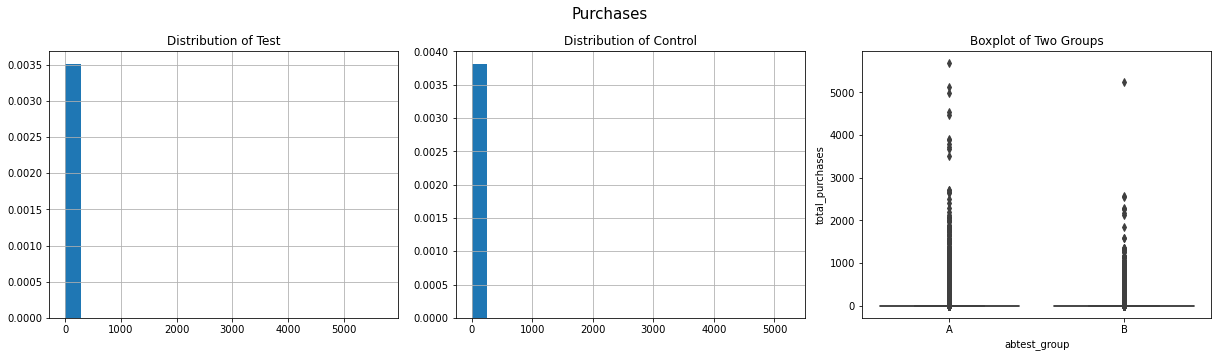

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5))
control_results.hist("total_purchases", density=True, bins=20, ax=ax[0])
test_results.hist("total_purchases", density=True, bins= 20, ax=ax[1])
sns.boxplot(x="abtest_group", y="total_purchases", data=df, ax=ax[2])

fig.suptitle("Purchases", fontsize=15)
ax[0].set_title("Distribution of Test", fontsize = 12)
ax[1].set_title("Distribution of Control", fontsize = 12)
ax[2].set_title("Boxplot of Two Groups", fontsize = 12)
plt.tight_layout(pad = 1)
plt.show()

In [80]:
grouped_df = df[["abtest_group", "total_gameends", "total_purchases"]].groupby(df["abtest_group"]).mean()
grouped_df_lift = (grouped_df.loc["B"] - grouped_df.loc["A"]) / grouped_df.loc["A"]

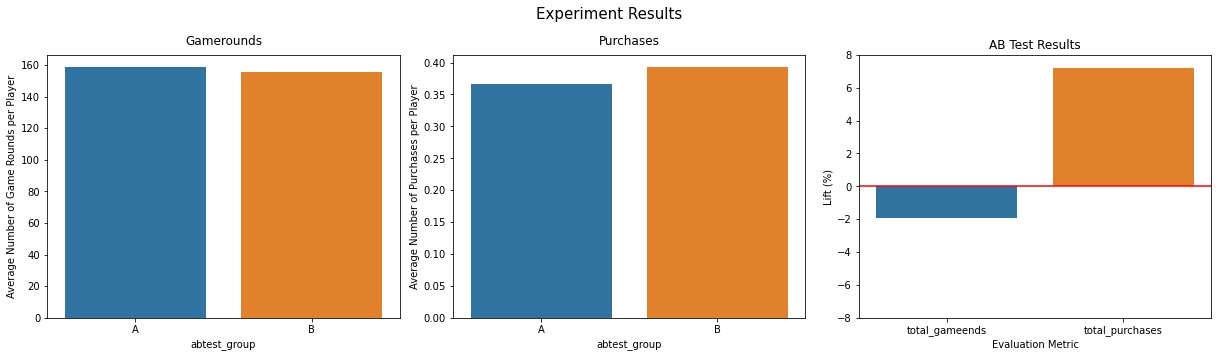

In [ ]:
grouped_df = df[["abtest_group", "total_gameends", "total_purchases"]].groupby(df["abtest_group"]).mean()
grouped_df_lift = (grouped_df.loc["B"] - grouped_df.loc["A"]) / grouped_df.loc["A"]

fig, ax = plt.subplots(1, 3, figsize=(17, 5))
sns.barplot(x=grouped_df.total_gameends.index, y=grouped_df.total_gameends, ax=ax[0])
sns.barplot(x=grouped_df.total_purchases.index, y=grouped_df.total_purchases, ax=ax[1])
sns.barplot(x=grouped_df_lift.index, y=grouped_df_lift*100, ax=ax[2])

fig.suptitle("Experiment Results", fontsize=15)
ax[0].set_title("Gamerounds", pad=10)
ax[0].set_ylabel("Average Number of Game Rounds per Player")
ax[1].set_title("Purchases", pad=10)
ax[1].set_ylabel("Average Number of Purchases per Player")
ax[2].set_ylim(-8, 8)
ax[2].set_title("AB Test Results")
ax[2].set_xlabel("Evaluation Metric")
ax[2].set_ylabel("Lift (%)")
plt.axhline(y=0, color='r', linestyle='-')
plt.tight_layout(pad = 1)
plt.show()

It would seem that our treatment has resulted in a decrease in the average number of gamerounds per player of around 2% (bummer!), but a substantial increase of around 7% in the average number of purchases made. 

To confirm these results, we will perform hypothesis tests.

In [ ]:
hypothesis_test(test_results["total_gameends"], control_results["total_gameends"], alternative="less")

MannwhitneyuResult(statistic=8373836786400.0, pvalue=0.0)

In [ ]:
hypothesis_test(test_results["total_purchases"], control_results["total_purchases"], alternative="greater")

MannwhitneyuResult(statistic=8536180046875.0, pvalue=0.4901617437975493)

This shows that we can be confident that there is a difference between the average number of gamerounds between the two groups, but we do not have sufficient evidence to say that the true average number of purchases is different between the two groups.

### Daily Data

We also want to look at the daily average number of gamerounds and purchases evolve throughout the experiment. After launching a new game feature, there may be early transitional effects of the changes introduced in the variants. Looking at the daily averages, rather than the total averages, may yield some interesting information. Let's look at daily average data. 

In [14]:
query1 = ('''
    WITH

    activity AS (
    SELECT *
        FROM `king-ds-recruit-candidate-635.abtest.activity` 
        WHERE activity_date BETWEEN "2017-05-04" AND "2017-05-22"
    ),

    joinTables AS (
    SELECT ass.playerid, ass.abtest_group, ac.activity_date, ac.gameends, ac.purchases, 
    FROM `king-ds-recruit-candidate-635.abtest.assignment` AS ass
    LEFT JOIN  activity AS ac
    ON ass.playerid=ac.playerid
    ),

    avg_by_date AS (
    SELECT abtest_group, activity_date, AVG(gameends) AS avg_gameends, STDDEV(gameends) AS std_gameends, 
        SUM(gameends) AS n_gameends, AVG(purchases) AS avg_purchases, STDDEV(purchases) AS std_purchases, 
        SUM(purchases) AS n_purchases
    FROM joinTables
    GROUP BY 1, 2
    ORDER BY activity_date, abtest_group
    )

    SELECT *
    FROM avg_by_date
    ''')

df1 = gcp2df(query1)

In [15]:
df1.head()  # contains the average number of gamerounds and purchases made each day of the experiment

,abtest_group,activity_date,avg_gameends,std_gameends,n_gameends,avg_purchases,std_purchases,n_purchases
0,A,2017-05-04,13.179551,10.238376,68597770,0.030555,0.757338,159035
1,B,2017-05-04,13.119000,10.180584,17040715,0.031852,0.775842,41374
2,A,2017-05-05,13.186148,10.250823,68498045,0.030470,0.768134,158282
3,B,2017-05-05,13.003362,10.096645,16868794,0.033394,0.772663,43321
4,A,2017-05-06,13.182186,10.235810,68755819,0.030389,0.771736,158504


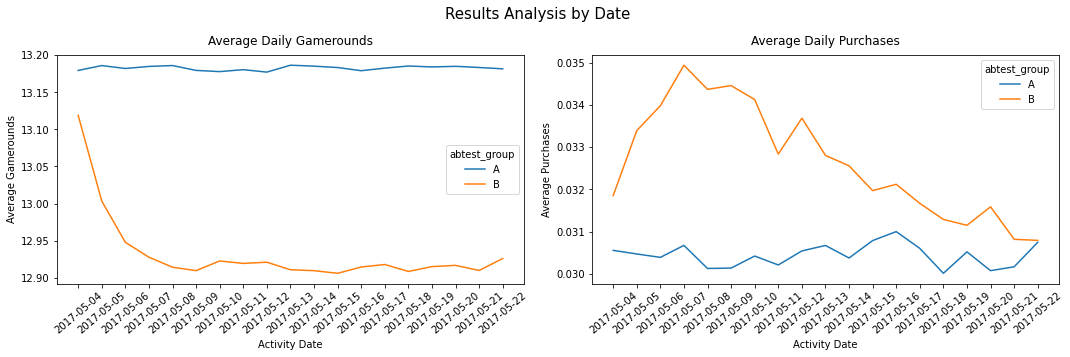

In [99]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
xticklabels = df1.activity_date.unique()
sns.lineplot(x="activity_date", y="avg_gameends", hue="abtest_group", data=df1, ax=ax[0])
sns.lineplot(x="activity_date", y="avg_purchases", hue="abtest_group", data=df1, ax=ax[1])
ax[0].set_xticklabels(xticklabels, rotation=40)
ax[1].set_xticklabels(xticklabels, rotation=40)
plt.suptitle("Results Analysis by Date", fontsize=15)
ax[0].set_xlabel("Activity Date")
ax[0].set_ylabel("Average Gamerounds")
ax[0].set_title("Average Daily Gamerounds", pad=10)
ax[1].set_xlabel("Activity Date")
ax[1].set_ylabel("Average Purchases")
ax[1].set_title("Average Daily Purchases", pad=10)
plt.tight_layout(pad=1)
plt.show()

On the left, we see that average number of gamerounds of the test group decreases right away and keeps constant, so we are more certain that the treatment has a negative effect on player engagement. 

However, on the right we see that the average number of daily purchases in the test group has a negative trend over time. By the end of the experiment, the purchases of the test group are equal to those in the control group, indicating that the 7% lift in the average number of purchases is likely to be transitory. To take more meaningful conclusions, we should wait for the purchases to stabilize. 

### Analysis by Player Type

It would be interesting to see if different types of players react differently to the treatment.

In [82]:
player_types = df[["abtest_group", "player_type", "total_gameends", "total_purchases"]].groupby(by=["player_type", "abtest_group", 
                                                                                    ]).agg(np.mean).reset_index()
player_types

,player_type,abtest_group,total_gameends,total_purchases
0,OG,A,184.112059,0.427444
1,OG,B,180.576797,0.455691
2,experienced,A,170.987525,0.389854
3,experienced,B,167.774378,0.428025
4,newbie,A,64.948765,0.150142
5,newbie,B,63.739933,0.155587


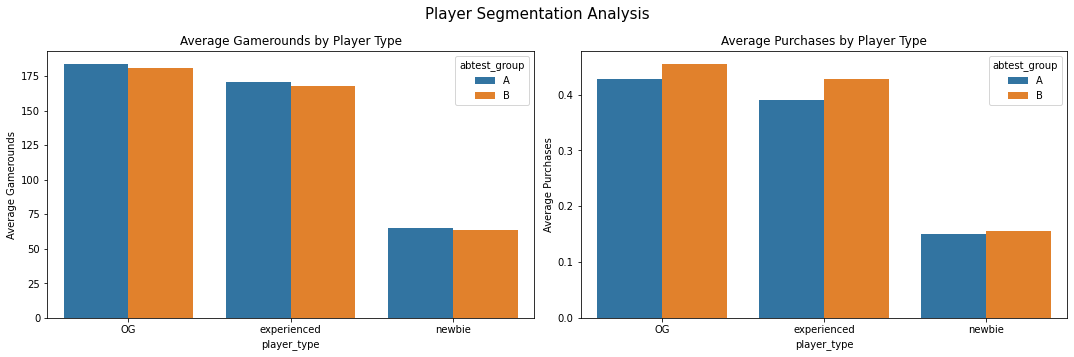

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x="player_type", y="total_gameends", hue="abtest_group", data=player_types, ax=ax[0])
sns.barplot(x="player_type", y="total_purchases", hue="abtest_group", data=player_types, ax=ax[1])

fig.suptitle("Player Segmentation Analysis", fontsize=15)
ax[0].set_title("Average Gamerounds by Player Type")
ax[0].set_ylabel("Average Gamerounds")
ax[1].set_title("Average Purchases by Player Type")
ax[1].set_ylabel("Average Purchases")
plt.tight_layout(pad=1)
plt.show()

The treatment's engagement and monetization lift appears less extreme for newbies for both gamerounds and purchases. Newbies are those that have installed the game after the start of the ab test and thus had never seen the control version of the game. 

This suggests that there isn't a significant difference between the two versions for new players, at least during the first weeks of play. 

In [125]:
df[["abtest_group", "player_type", "day_2_retention", "day_7_retention", "days_to_convert", "paying_user"]].groupby(by=["player_type", "abtest_group"]).agg(["mean"]).style.format('{:.3f}')

## 5. What type of change to the game do you think was tested here?

Knowing the type of change introduced to the game is important before deciding whether to recommend the treatment or reject it.

Let's remember the business problem! Players need to solve math questions to progress through a map. The game is Free to Play meaning that players can download and play the game for free but can optionally buy hints on the levels.

The results show an increase in the average purchases (although statistically not significant) that starts falling after the first week, but a decrease in engagement. We also see that the change has almost no effect on new players. 

This seems to suggest that the next set of new levels has been introduced to the game. The hypothesis would explain why the change has almost no effect on new players -they are unlikely to reach these higher levels in just a couple of weeks-, and would explain both an increase in purchases and a slight decrease in engagement -now players have more levels to get stuck on and pay (particularly experienced players that had reached the end), but the fact that the later levels are harder can make them lose the motivation to keep playing-. The sudden drop of purchases after a week could be explained by the experienced players reaching the final level again.


## 5. Conclusion

In this experiment, we analyzed the data provided to determine wether the test variant makes Super Math Saga a better game. The main takaways are as follows:

The results of the analysis indicate that there is a statistical significance that the test group has a lower engagement than the control group. 

In terms of monetization, we have not been able to proof that the test variant produces a statistical significant lift over the control. Additionally, we have observed that despite an initial increase in purchases of the test variant on the first few days of the test, the trend starts to fall thereafter until the two variants look nearly identical.

A further analysis by player type suggests that the two variants perform nearly identically in new players in terms of engagement and monetization, and the effect mainly affects more experienced players.

For all these reasons and without more information on the experiment that was performed, we cannot conclude that the change introduced to the game is a significant improvement over the control variant, and we cannot recommend that the test variant is launched. 

In [1]:
# ______________________________________________

Thank you for completing the King Super Math Saga analysis! For your last interview we would like you to come and present your findings and what should we do next. It is an opportunity for you to show your persuasiveness, creativity and how you respond to feedback. We are interested in your ideas:

 

How to iterate on the test – could we tweak it to improve performance?

What areas would you focus your analysis on next? you may have already mentioned a few in your report, lets discuss them

What are the implications for the business? Which actions would you suggest? Who should we engage?

Ideas:

Power analysis, how many data points do we need? Could we have lowered the risk with a smaller test population?

## K-Means Clustering

In [3]:
activity_summary_stats = ('''
    WITH

    activity_summary_stats AS (
    SELECT playerid, COUNT(activity_date) AS days_played,
        SUM(purchases) AS lifetime_purchases, MAX(purchases) AS max_daily_purchases, AVG(purchases) AS avg_daily_purchases, STDDEV(purchases) AS      std_purchases,
        SUM(gameends) AS lifetime_gameends, MAX(gameends) AS max_daily_gameends, AVG(gameends) AS avg_daily_gameends, STDDEV(gameends) as std_gameends
    FROM `king-ds-recruit-candidate-635.abtest.activity`
    GROUP BY playerid
    ), 

    purchase_days AS (
    SELECT playerid, COUNT(purchases) AS purchase_days
    FROM `king-ds-recruit-candidate-635.abtest.activity`
    WHERE purchases > 0
    GROUP BY playerid
    ), 

    date_diff AS (
    SELECT playerid, DATE_DIFF(PARSE_DATE("%Y-%m-%d", MAX(activity_date)), PARSE_DATE("%Y-%m-%d", MIN(activity_date)), DAY) AS date_diff
    FROM `king-ds-recruit-candidate-635.abtest.activity`
    GROUP BY playerid
    ),

    join_tables AS (
    SELECT asa.*, IFNULL(pd.purchase_days, 0) AS purchase_days, date_diff
    FROM activity_summary_stats AS asa
        LEFT JOIN purchase_days AS pd
        ON asa.playerid = pd.playerid
        LEFT JOIN date_diff AS dd
        ON asa.playerid = dd.playerid
    )

    SELECT *
    FROM join_tables
    ''')

df2 = gcp2df(activity_summary_stats)

In [106]:
# df2.to_csv("../../../activity_summary_stats.csv")
df2 = pd.read_csv("../../../activity_summary_stats.csv", index_col=0)

In [17]:
df2.head()

,playerid,days_played,lifetime_purchases,max_daily_purchases,avg_daily_purchases,std_purchases,lifetime_gameends,max_daily_gameends,avg_daily_gameends,std_gameends,purchase_days,date_diff
0,32493786,31,0,0,0.0,0.0,304,16,9.806452,3.789629,0,32
1,9136130,31,0,0,0.0,0.0,521,24,16.806452,3.824651,0,32
2,29937133,31,0,0,0.0,0.0,262,14,8.451613,2.514474,0,31
3,42102526,31,0,0,0.0,0.0,394,20,12.709677,3.796433,0,32
4,38424943,31,0,0,0.0,0.0,488,21,15.741935,2.632714,0,32


In [18]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11684762 entries, 0 to 11684761
Data columns (total 12 columns):
 #   Column               Dtype  
---  ------               -----  
 0   playerid             int64  
 1   days_played          int64  
 2   lifetime_purchases   int64  
 3   max_daily_purchases  int64  
 4   avg_daily_purchases  float64
 5   std_purchases        float64
 6   lifetime_gameends    int64  
 7   max_daily_gameends   int64  
 8   avg_daily_gameends   float64
 9   std_gameends         float64
 10  purchase_days        int64  
 11  date_diff            int64  
dtypes: float64(4), int64(8)
memory usage: 1.1 GB


In [109]:
df2 = df2.fillna(0)

In [20]:
df2_sample = df2.sample(frac=0.1, random_state=13)

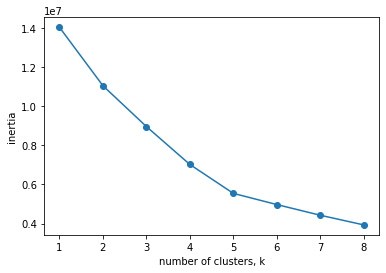

In [132]:
ks = range(1, 9)
inertias = []
centroids = []

scaler = StandardScaler()

for k in ks:
    # Create a KMeans instance with k clusters: model
    kmeans = KMeans(n_clusters=k)
    
    # Create pipeline: pipeline
    pipeline = make_pipeline(scaler, kmeans)

    # Fit model to samples
    pipeline.fit(df2_sample)
    
    # Append the inertia and centroids to the existing lists
    inertias.append(kmeans.inertia_)
    centroids.append(kmeans.cluster_centers_)

# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


In [34]:
scaler = StandardScaler()
kmeans = KMeans(n_clusters=5)
pipeline = make_pipeline(scaler, kmeans)

pipeline.fit(df2)
labels = pipeline.predict(df2)

In [110]:
#pickle.dump(kmeans, open("kmeans.sav", 'wb'))
#pickle.dump(scaler, open("scaler.sav", 'wb'))
kmeans = pickle.load(open("kmeans.sav", 'rb'))
scaler = pickle.load(open("scaler.sav", 'rb'))

In [111]:
pipeline = make_pipeline(scaler, kmeans)
pipeline.fit(df2)
labels = pipeline.predict(df2)

In [112]:
df2_centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_))
df2_centroids.columns = df2.columns
df2_centroids

,playerid,days_played,lifetime_purchases,max_daily_purchases,avg_daily_purchases,std_purchases,lifetime_gameends,max_daily_gameends,avg_daily_gameends,std_gameends,purchase_days,date_diff
0,3.100526e+07,24.203220,0.071006,0.019754,0.003023,0.006241,265.922954,17.856934,11.035153,3.237877,0.062932,30.397339
1,4.767421e+07,4.711556,0.045050,0.026022,0.014178,0.007683,51.909640,14.320048,11.791186,1.854559,0.034241,4.782143
2,3.343708e+07,21.897431,0.010760,0.004791,0.003109,0.001231,873.348081,53.594419,41.342833,6.211822,0.006328,27.207844
3,3.406067e+07,20.742217,1201.000000,92.645081,61.587057,15.291844,477.981320,31.403487,22.958057,4.288583,20.742217,25.770859
4,3.218899e+07,23.238966,32.560662,4.221753,1.562793,1.148413,366.478576,23.757443,16.045691,3.765503,13.150223,28.904725


In [113]:
df2["cluster"] = labels
df2.cluster.value_counts(normalize=True, sort=False)*100

0    63.589673
1    29.043809
2     6.056144
3     0.006872
4     1.303501
Name: cluster, dtype: float64

In [27]:
conditions = [
    (df2.cluster == 0),
    (df2.cluster == 1),
    (df2.cluster == 2),
    (df2.cluster == 3),
    (df2.cluster == 4)
]
values = ["common carp", "crab", "shark", "whale", "dolphin"]
df2_centroids["segment"] = values
df2["segment"] = np.select(conditions, values)

In [77]:
df2_centroids

,playerid,days_played,lifetime_purchases,max_daily_purchases,avg_daily_purchases,std_purchases,lifetime_gameends,max_daily_gameends,avg_daily_gameends,std_gameends,purchase_days,date_diff,segment
0,3.100523e+07,24.203246,0.071011,0.019755,0.003023,0.006241,265.908607,17.856130,11.034517,3.237794,0.062936,30.397359,common carp
1,3.343735e+07,21.897083,0.010757,0.004791,0.003110,0.001231,873.165220,53.585376,41.334998,6.211184,0.006328,27.207585,shark
2,3.406067e+07,20.742217,1201.000000,92.645081,61.587057,15.291844,477.981320,31.403487,22.958057,4.288583,20.742217,25.770859,whale
3,3.218901e+07,23.238968,32.560817,4.221768,1.562801,1.148417,366.479590,23.757507,16.045736,3.765513,13.150263,28.904704,dolphin
4,4.767421e+07,4.711518,0.045049,0.026022,0.014177,0.007683,51.908301,14.319668,11.790857,1.854522,0.034240,4.782100,crab


In [28]:
df2.head()

,playerid,days_played,lifetime_purchases,max_daily_purchases,avg_daily_purchases,std_purchases,lifetime_gameends,max_daily_gameends,avg_daily_gameends,std_gameends,purchase_days,date_diff,cluster,segment
0,32493786,31,0,0,0.0,0.0,304,16,9.806452,3.789629,0,32,0,common carp
1,9136130,31,0,0,0.0,0.0,521,24,16.806452,3.824651,0,32,0,common carp
2,29937133,31,0,0,0.0,0.0,262,14,8.451613,2.514474,0,31,0,common carp
3,42102526,31,0,0,0.0,0.0,394,20,12.709677,3.796433,0,32,0,common carp
4,38424943,31,0,0,0.0,0.0,488,21,15.741935,2.632714,0,32,0,common carp


In [33]:
#df2.to_csv("../../../df2_clusters.csv")

In [42]:
df = df.merge(df2[["playerid", "segment"]], how="left", on="playerid")
df.head()

,playerid,abtest_group,assignment_date,install_date,conversion_date,total_gameends,total_purchases,days_played,days_since_installed,days_to_convert,paying_user,player_type,day_2_retention,day_7_retention,segment
0,12375489,A,2017-05-04,2016-05-02,NaT,204,0,16,385,NaN,False,OG,True,True,common carp
1,30548310,A,2017-05-04,2016-11-01,NaT,247,0,13,202,NaN,False,OG,True,True,common carp
2,41099711,A,2017-05-04,2017-02-13,NaT,159,0,13,98,NaN,False,OG,True,True,common carp
3,26239061,A,2017-05-04,2016-09-19,NaT,56,0,6,245,NaN,False,OG,True,False,common carp
4,6191990,A,2017-05-04,2016-03-02,NaT,98,0,14,446,NaN,False,OG,True,True,common carp


In [93]:
df.groupby("segment").abtest_group.value_counts(normalize=True)

segment      abtest_group
common carp  A               0.799993
             B               0.200007
crab         A               0.799327
             B               0.200673
dolphin      A               0.795812
             B               0.204188
shark        A               0.804250
             B               0.195750
whale        A               0.794702
             B               0.205298
Name: abtest_group, dtype: float64

In [85]:
player_segments = df[["abtest_group", "segment", "total_gameends", "total_purchases"]].groupby(by=["segment", "abtest_group"]).agg(np.mean).reset_index()
player_segments

,segment,abtest_group,total_gameends,total_purchases
0,common carp,A,153.940728,0.041318
1,common carp,B,151.504183,0.040549
2,crab,A,50.250336,0.042352
3,crab,B,49.685704,0.042789
4,dolphin,A,218.147297,19.206238
5,dolphin,B,212.815737,20.126347
6,shark,A,532.363919,0.006188
7,shark,B,525.847897,0.005169
8,whale,A,292.258333,727.858333
9,whale,B,294.477419,783.580645


In [59]:
player_segments_lift = 100 * (player_segments.set_index(["abtest_group", "segment"]).loc["B"] - player_segments.set_index(["abtest_group", "segment"]).loc["A"]) /  player_segments.set_index(["abtest_group", "segment"]).loc["A"]
player_segments_lift

,total_gameends,total_purchases
segment,,
common carp,-1.582782,-1.860281
crab,-1.123639,1.033566
dolphin,-2.444019,4.790678
shark,-1.223979,-16.477761
whale,0.759289,7.655653


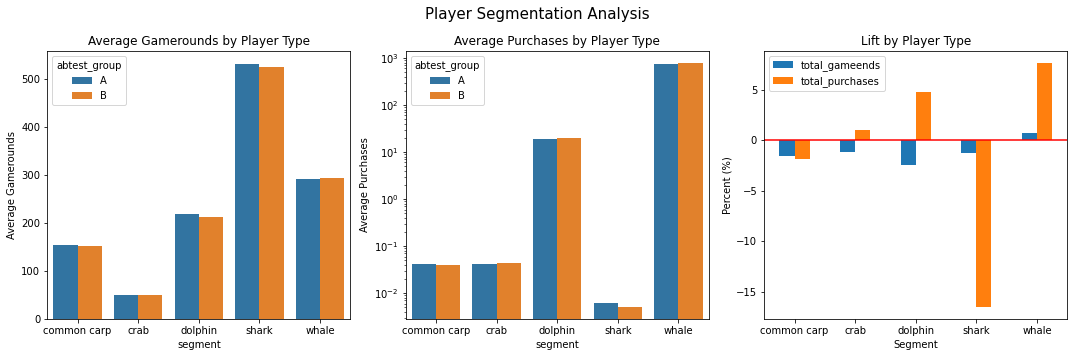

In [83]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(x="segment", y="total_gameends", hue="abtest_group", data=player_segments, ax=ax[0])
sns.barplot(x="segment", y="total_purchases", hue="abtest_group", data=player_segments, ax=ax[1])
player_segments_lift.plot(kind="bar", ax=ax[2])

fig.suptitle("Player Segmentation Analysis", fontsize=15)
ax[0].set_title("Average Gamerounds by Player Type")
ax[0].set_ylabel("Average Gamerounds")
ax[1].set_title("Average Purchases by Player Type")
ax[1].set_ylabel("Average Purchases")
ax[1].set_yscale("log")
ax[2].axhline(y=0, color='r', linestyle='-')
ax[2].set_title("Lift by Player Type")
ax[2].set_xlabel("Segment")
ax[2].set_xticklabels(player_segments_lift.index, rotation=0)
ax[2].set_ylabel("Percent (%)")
plt.tight_layout(pad=1)
plt.show()